In [2]:
# 安装依赖
!pip install segmentation-models-pytorch lightning monai wandb -U yacs nibabel albumentations tabulate
!git clone https://github.com/by-liu/SegLossBias.git
!pip install einops
import sys
import yacs
sys.path.append('./SegLossBias')
# 清除输出
import IPython


# 核心库
import os
from os.path import join

# 数据处理与数组操作
import numpy as np
import nibabel as nib

# 可视化库
import matplotlib.pyplot as plt

# 进度条
from tqdm import tqdm

# PyTorch 基础及相关库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchmetrics

# 高级模型和训练库
import pytorch_lightning as pl
from pytorch_lightning import Trainer, LightningDataModule
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.tuner.tuning import Tuner

# 自定义搭建模型
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

# 数据增强库
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 复合损失函数
import monai
from monai.losses import *

# 数据分割
from sklearn.model_selection import train_test_split

# Weights & Biases 工具
import wandb
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.core.mixins import HyperparametersMixin
IPython.display.clear_output()

# 这里是数据加载流程制作

torch.Size([16, 1, 256, 256])
torch.Size([16, 256, 256])


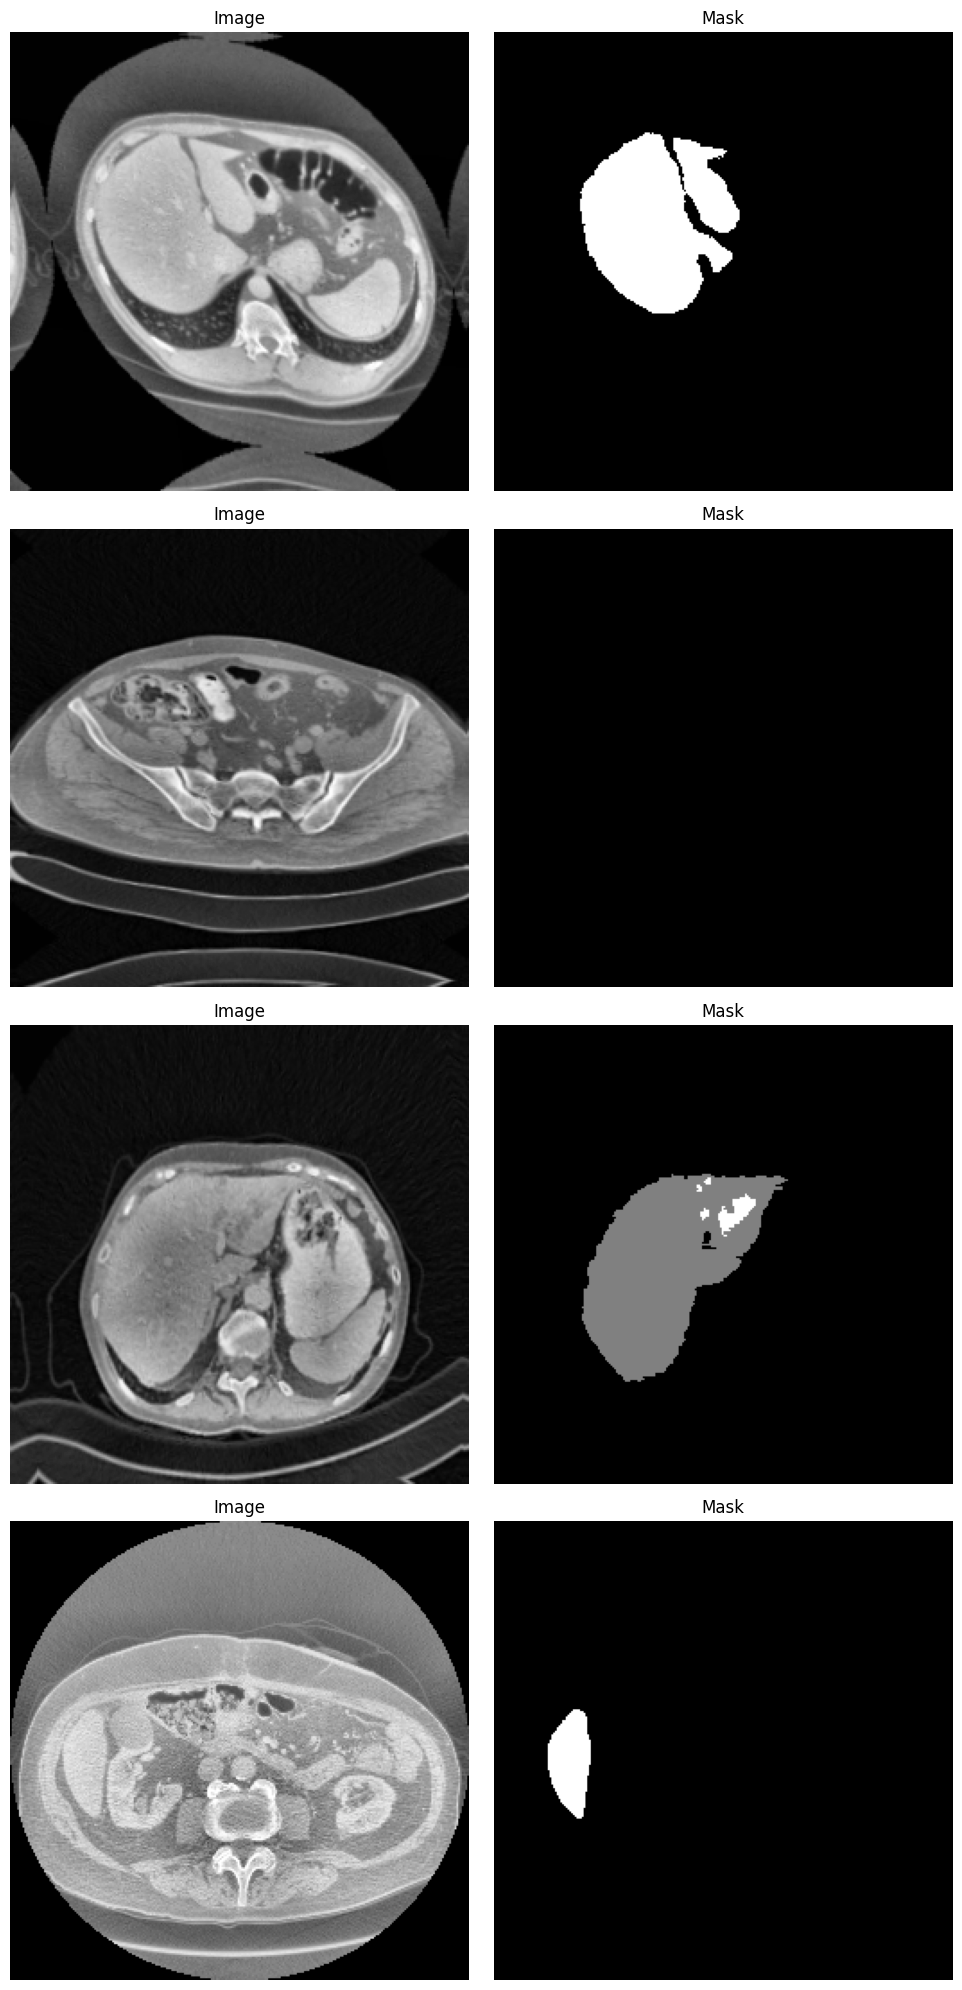

In [3]:
import torchvision.utils as vutils

# 定义数据增强
train_transform = A.Compose([
#     A.Resize(256, 256),
    # A.HorizontalFlip(p=0.15),
    # A.VerticalFlip(p=0.15),
    # A.RandomRotate90(p=0.1),
    A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.15, alpha_affine=120 * 0.15),
    A.RandomSizedCrop(min_max_height=(192, 256), height=256, width=256, p=0.15),
    ToTensorV2(),
])

val_transform = A.Compose([
#     A.Resize(256, 256),
    ToTensorV2(),
])

def adjust_window(image, window_center, window_width):
    """
    调整CT图像的窗宽窗位。
    :param image: 输入的图像数组。
    :param window_center: 窗位（WC）。
    :param window_width: 窗宽（WW）。
    :return: 调整窗宽窗位后的图像。
    """
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed_img = np.clip(image, img_min, img_max)
    # print(windowed_img.dtype) # NOW its float64
    return windowed_img

class MultipleImageDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        """
        image_paths: 图像文件路径列表
        label_paths: 标签文件路径列表
        transform: 应用于图像和标签的转换操作
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = (np.load(self.image_paths[idx]))['arr_0']
#         print(image.shape)
        label = (np.load(self.label_paths[idx]))['arr_0']
#         print(label.shape)

        image = adjust_window(image, window_center=40, window_width=400)

        augmented = self.transform(image=image, mask=label)
        image = augmented['image']
        label = augmented['mask']
        image = image.float()
        label = label.long()

        label = label.long()
        image = (image - image.min()) / (image.max() - image.min())

        return image.float(), label.long()

######################################################################################################################
class LiTSDataModule(LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int = 16):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.val_transform = val_transform

    def setup(self, stage=None):
        image_dir = os.path.join(self.data_dir, 'clahe_images') # 图像文件夹名称
        label_dir = os.path.join(self.data_dir, 'clahe_masks') # 掩码文件夹名称

        # 读取文件路径
        image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.npz')])
        label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.npz')])

        # 划分训练集、验证集、测试集
        train_size = int(0.8 * len(image_files))
        val_size = int(0.1 * len(image_files))

        self.train_image_paths = image_files[:train_size]
        self.val_image_paths = image_files[train_size:train_size + val_size]
        self.test_image_paths = image_files[train_size + val_size:]

        self.train_label_paths = label_files[:train_size]
        self.val_label_paths = label_files[train_size:train_size + val_size]
        self.test_label_paths = label_files[train_size + val_size:]

    def train_dataloader(self):
        train_dataset = MultipleImageDataset(self.train_image_paths, self.train_label_paths, transform=self.train_transform)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)

    def val_dataloader(self):
        val_dataset = MultipleImageDataset(self.val_image_paths, self.val_label_paths, transform=self.val_transform)
        return DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    def test_dataloader(self):
        test_dataset = MultipleImageDataset(self.test_image_paths, self.test_label_paths, transform=self.val_transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    def show_batch(self, n_images=4):
        """显示数据批次中的图像和标签"""
        train_loader = self.train_dataloader()
        data_iter = iter(train_loader)
        images, masks = next(data_iter)
        print(images.shape)
        print(masks.shape)

        fig, axs = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))
        for idx in range(n_images):
            axs[idx, 0].imshow(images[idx][0], cmap='gray')
            axs[idx, 0].set_title('Image')
            axs[idx, 0].axis('off')

            axs[idx, 1].imshow(masks[idx], cmap='gray') 
            axs[idx, 1].set_title('Mask')
            axs[idx, 1].axis('off')

        plt.tight_layout()
        plt.show()


# 使用 DataModule
data_module = LiTSDataModule(data_dir='./') # 这里替换为大文件夹的地址
data_module.setup()
data_module.show_batch(n_images=4)

# DiceCELoss搭配KL散度的实现，能减缓过拟合

In [4]:
from seglossbias.modeling.compound_losses import *
from monai.losses.dice import *
from torch.nn.modules.loss import _Loss

class DiceCELossWithKL(_Loss): # 添加KL散度
    def __init__(
        self,
        mode: str = 'MULTICLASS_MODE',
        include_background: bool = True,
        to_onehot_y: bool = False,
        sigmoid: bool = False,
        softmax: bool = False,
        other_act: Callable | None = None,
        squared_pred: bool = False,
        jaccard: bool = False,
        reduction: str = "mean",
        smooth_nr: float = 1e-5,
        smooth_dr: float = 1e-5,
        batch: bool = False,
        ce_weight: torch.Tensor | None = None,
        weight: torch.Tensor | None = None,
        lambda_dice: float = 1.0,
        lambda_ce: float = 1.0,
        lambda_kl: float = 1.0,  # KL divergence weight
        temp: float = 10.0
    ) -> None:

        super().__init__()
        self.mode = mode  # 设置mode
        self.temp = temp  # 设置temp
        reduction = look_up_option(reduction, DiceCEReduction).value
        weight = ce_weight if ce_weight is not None else weight
        dice_weight: torch.Tensor | None
        if weight is not None and not include_background:
            dice_weight = weight[1:]
        else:
            dice_weight = weight
        self.dice = DiceLoss(
            include_background=include_background,
            to_onehot_y=to_onehot_y,
            sigmoid=sigmoid,
            softmax=softmax,
            other_act=other_act,
            squared_pred=squared_pred,
            jaccard=jaccard,
            reduction=reduction,
            smooth_nr=smooth_nr,
            smooth_dr=smooth_dr,
            batch=batch,
            weight=dice_weight,
        )
        self.cross_entropy = nn.CrossEntropyLoss(weight=weight, reduction=reduction)
        self.binary_cross_entropy = nn.BCEWithLogitsLoss(pos_weight=weight, reduction=reduction)
        if lambda_dice < 0.0:
            raise ValueError("lambda_dice should be no less than 0.0.")
        if lambda_ce < 0.0:
            raise ValueError("lambda_ce should be no less than 0.0.")
        self.lambda_dice = lambda_dice
        self.lambda_ce = lambda_ce
        self.old_pt_ver = not pytorch_after(1, 10)
        self.lambda_kl = lambda_kl

    def ce(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Compute CrossEntropy loss for the input logits and target.
        Will remove the channel dim according to PyTorch CrossEntropyLoss:
        https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?#torch.nn.CrossEntropyLoss.

        """
        n_pred_ch, n_target_ch = input.shape[1], target.shape[1]
        if n_pred_ch != n_target_ch and n_target_ch == 1:
            target = torch.squeeze(target, dim=1)
            target = target.long()
        elif self.old_pt_ver:
            warnings.warn(
                f"Multichannel targets are not supported in this older Pytorch version {torch.__version__}. "
                "Using argmax (as a workaround) to convert target to a single channel."
            )
            target = torch.argmax(target, dim=1)
        elif not torch.is_floating_point(target):
            target = target.to(dtype=input.dtype)

        return self.cross_entropy(input, target)  # type: ignore[no-any-return]

    def bce(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Compute Binary CrossEntropy loss for the input logits and target in one single class.

        """
        if not torch.is_floating_point(target):
            target = target.to(dtype=input.dtype)

        return self.binary_cross_entropy(input, target)  # type: ignore[no-any-return]

    def kl_div(self, p, q):
        """ Calculate KL divergence """
        kl = p * torch.log((p + 1e-10) / (q + 1e-10))
        return kl.sum()

    def convert_to_one_hot(self, targets, num_classes):
        targets = torch.squeeze(targets, dim=1)

        # 转换为one-hot [batch_size, height, width, num_classes]
        targets_one_hot = F.one_hot(targets, num_classes=num_classes)

        # 转置维度以匹配输出 [batch_size, num_classes, height, width]
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2)

        return targets_one_hot

    def calculate_gt_proportion(self, targets_one_hot):
        # targets_one_hot: [batch_size, num_classes, height, width]
        # 计算每个类别的总像素数
        class_totals = targets_one_hot.sum(dim=[0, 2, 3])  # 按照批次和空间维度聚合

        # 避免除以零，使用一个小的epsilon
        epsilon = 1e-8
        # 计算每个类别的比例
        gt_proportion = class_totals / (class_totals.sum() + epsilon)

        return gt_proportion

    def calculate_pred_proportion(self, preds):
        # preds: [batch_size, num_classes, height, width], 模型输出的概率分布
        # 计算每个类别的预测概率总和
        pred_totals = preds.sum(dim=[0, 2, 3])  # 按照批次和空间维度聚合

        # 避免除以零，使用一个小的epsilon
        epsilon = 1e-8
        # 计算每个类别的预测概率比例
        pred_proportion = pred_totals / (pred_totals.sum() + epsilon)

        return pred_proportion

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            input: the shape should be BNH[WD].
            target: the shape should be BNH[WD] or B1H[WD].

        Raises:
            ValueError: When number of dimensions for input and target are different.
            ValueError: When number of channels for target is neither 1 nor the same as input.

        """
        if len(input.shape) != len(target.shape):
            raise ValueError(
                "the number of dimensions for input and target should be the same, "
                f"got shape {input.shape} and {target.shape}."
            )

        dice_loss = self.dice(input, target)
        ce_loss = self.ce(input, target) if input.shape[1] != 1 else self.bce(input, target)
        preds = F.softmax(self.temp * input, dim=1)

        target_one_hot = self.convert_to_one_hot(target, num_classes=input.size(1))
        gt_proportion = self.calculate_gt_proportion(target_one_hot)
        pred_proportion = self.calculate_pred_proportion(preds)


            # Print the values of the losses
#         print(f"Dice Loss: {dice_loss.item()}")
#         print(f"CE Loss: {ce_loss.item()}")
#         print(f"KL Divergence Regularizer: {regularizer.item()}")
        kl_loss = self.kl_div(gt_proportion, pred_proportion)


        total_loss: torch.Tensor = self.lambda_dice * dice_loss + self.lambda_ce * ce_loss + self.lambda_kl * kl_loss
#         print(f"gt: {gt_proportion}")
#         print(f"pred: {pred_proportion}")
#         print(f"kl_loss: {kl_loss}")
#         print(f"total_loss: {total_loss}")
        return total_loss


# 模型搭建

利用了smp的零件来自定义ResUNet50 + scse 注意力机制

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from segmentation_models_pytorch.base import modules as md


class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = md.Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = md.Attention(attention_type, in_channels=in_channels + skip_channels)
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = md.Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        use_batchnorm=True,
        attention_type=None,
        center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[1:]
        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(head_channels, head_channels, use_batchnorm=use_batchnorm)
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):

        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x

你可以在这里调整backbone Unet的参数获取更好效果，比如：

`encoder_depth`, `decoder_channels`来构建更深的网络，但是要注意他们要等深度

也就是5层深度的encoder，要求5层深度的decoder_channels

In [7]:
from typing import Optional, Union, List

from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import (
    SegmentationModel,
    SegmentationHead,
)

class Unet(SegmentationModel):
    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        self.name = "u-{}".format(encoder_name)
        self.initialize()

# 模型详细配置

In [9]:
class LiTSModel(pl.LightningModule, HyperparametersMixin):
    def __init__(
        self,
        in_channels=1,
        # 你可以用这里的默认loss
#         loss_fn=monai.losses.DiceCELoss(softmax=True, lambda_dice=1.0, lambda_ce=1.0, to_onehot_y=True, include_background=False),
        loss_fn=DiceCELossWithKL(softmax=True, lambda_dice=1.0, lambda_ce=1.0, lambda_kl=2.0, to_onehot_y=True, include_background=False),
        learning_rate=1e-3,
        classes=3,
        ):
        super().__init__()
        self.save_hyperparameters()
        ###################### model #########################
        self.model = smp.Unet(
            encoder_name='resnet50', 
            encoder_weights='imagenet',
            in_channels=in_channels,
            classes=classes,
            decoder_attention_type='scse',
        )
        self.loss_fn = loss_fn
        ###################### metrics ######################
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=3, ignore_index=0)

        self.Dice = torchmetrics.Dice(multiclass=True, num_classes=3, ignore_index=0, average='macro')

        self.F1 = torchmetrics.F1Score(task='multiclass', num_classes=3, average='macro', ignore_index=0)
        self.F1_classwise = torchmetrics.F1Score(task='multiclass', num_classes=3, average='none')

        self.Jaccard = torchmetrics.JaccardIndex(task='multiclass', num_classes=3, average='micro', ignore_index=0)
        self.Jaccard_classwise = torchmetrics.JaccardIndex(task='multiclass', num_classes=3, average='none')
        #####################################################

    # 定义前向传播
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
#         print(outputs.shape)
#         print(labels.shape)
        loss = self.loss_fn(outputs, labels.unsqueeze(1))
        Dice = self.Dice(outputs, labels)
        self.log('train_loss', loss, on_step=True, logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
#         print("val_step going")
        images, labels = batch
        outputs = self.forward(images)

        loss = self.loss_fn(outputs, labels.unsqueeze(1))

        preds = torch.argmax(outputs, dim=1)



        acc = self.accuracy(preds, labels)
        Dice = self.Dice(preds, labels)
        self.log('val_loss', loss, on_epoch=True, logger=True, prog_bar=True)
        self.log('val_accuracy', acc, on_epoch=True, logger=True, prog_bar=True)
        self.log('val_Dice', Dice, on_epoch=True, logger=True, prog_bar=True)

        self.log('val_F1', self.F1(preds, labels), on_epoch=True, logger=True, prog_bar=True)
        self.organ_names = {
            0: 'background', 1: 'liver', 2: 'tumor',
        }
        F1_classwise = self.F1_classwise(preds, labels)
        for i, name in self.organ_names.items():
            self.log(f'val_F1_{name}', F1_classwise[i], on_epoch=True, logger=True, prog_bar=True)

        self.log('val_Jaccard', self.Jaccard(preds, labels), on_epoch=True, logger=True, prog_bar=True)
        self.organ_names = {
            0: 'background', 1: 'liver', 2: 'tumor',
        }
        Jaccard_classwise = self.Jaccard_classwise(preds, labels)
        for i, name in self.organ_names.items():
            self.log(f'val_Jaccard_{name}', Jaccard_classwise[i], on_epoch=True, logger=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)

        loss = self.loss_fn(outputs, labels.unsqueeze(1))
        preds = torch.argmax(outputs, dim=1)

        acc = self.accuracy(preds, labels)
        Dice = self.Dice(preds, labels)
        self.log('test_loss', loss, on_epoch=True, logger=True, prog_bar=True)
        self.log('test_accuracy', acc, on_epoch=True, logger=True, prog_bar=True)
        self.log('test_Dice', Dice, on_epoch=True, logger=True, prog_bar=True)

        F1_classwise = self.F1_classwise(preds, labels)
        organ_names = {
            0: 'background', 1: 'liver', 2: 'tumor',
        }
        for i, name in organ_names.items():
            self.log(f'test_F1_{name}', F1_classwise[i], on_epoch=True, logger=True, prog_bar=True)

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_closure, **kwargs):
        # 调用优化器的step方法前执行自定义操作
        # 比如实现学习率热启动
        if self.trainer.global_step < 100:
            lr_scale = min(1.0, float(self.trainer.global_step + 1) / 100.0)
            for pg in optimizer.param_groups:
                pg["lr"] = lr_scale * self.hparams.learning_rate
        # 调用优化器的step方法来更新模型参数
        optimizer.step(closure=optimizer_closure)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

model = LiTSModel(classes=3)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.


# 开练

我用wandb做初始化，所以请注册好wandb，获取密钥（api key）来做下一步

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import monai
import re


suffix = "ResUNet50_scse_DiceCELossWithKL" 

# 配置TensorBoardLogger
wandb_logger = WandbLogger(project="LiTS", name=suffix)
# 创建一个模型检查点回调
# 监控 'val_acc' 指标，保存指标最好的模型
checkpoint_callback = ModelCheckpoint(
    monitor='val_F1_tumor',     # 指定要监控的指标 ，我监测肿瘤的精度最高的时候保存模型
    dirpath='checkpoints/',  # 指定保存模型的目录
    filename='best-checkpoint',  # 模型保存的文件名
    save_top_k=1,          # 只保存一个模型，即最好的模型
    mode='max'             # 最大化监控指标
)

# 创建训练器并启动训练
trainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[checkpoint_callback],  # 将回调传递给训练器
    max_epochs=50,
    fast_dev_run=True, # 测试用，正式训练请注释掉
    # benchmark=True, # 打鸡血训练用
)

# 开始训练
trainer.fit(model, datamodule=data_module)
trainer.validate(model, datamodule=data_module)
trainer.test(model, datamodule=data_module)

# 下面是上传模型到云端的代码，你可以保存到本地，不用存云端
# # 模型存储的目录
# model_directory = "/kaggle/working/checkpoints/"

# # 遍历目录中的所有 .ckpt 文件
# for filename in os.listdir(model_directory):
#     if filename.endswith(".ckpt"):
#         # 创建模型的完整路径
#         filepath = os.path.join(model_directory, filename)
#         # 清洗文件名以创建合法的 Artifact 名称
#         clean_name = re.sub(r'[^a-zA-Z0-9_\-.]', '_', filename[:-5]) + "_" + suffix
#         # 创建一个用于版本控制的 Artifact
#         artifact = wandb.Artifact(name=clean_name, type=suffix)  # 移除文件名中的 .ckpt
#         artifact.add_file(filepath)

#         # 上传 Artifact
#         wandb.log_artifact(artifact)

# 训练完后看看分割情况

In [ ]:
# 确保模型处于评估模式
model.eval()
print("eval activated")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
test_loader = data_module.val_dataloader() # 可以切换为train_dataloader/val_dataloader/test_dataloader，train_dataloader的效果总会更好，你懂的


# 定义一个函数来执行预测并绘图
def predict_and_log_images(num_samples=2):
    indices = torch.randperm(len(test_loader.dataset))[:num_samples]
    fig, axs = plt.subplots(num_samples, 6, figsize=(20, 10 * num_samples))  # 调整subplot大小

    for i, idx in enumerate(indices):
        image, mask = test_loader.dataset[idx]
        image = image.unsqueeze(0).to(device)  # 添加batch维度并移动到设备
        mask = mask.squeeze()  # 移除batch维度（如果有的话）

        with torch.no_grad():
            pred = model(image)
            prediction = torch.argmax(pred, dim=1).cpu()  # 获取预测类别并移回CPU

        axs[i, 0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
        axs[i, 0].set_title(f'Original Image {i+1}')
        axs[i, 1].imshow(mask.cpu().numpy(), cmap='gray')
        axs[i, 1].set_title(f'True Mask {i+1}')
        axs[i, 2].imshow(prediction[0].numpy(), cmap='gray')
        axs[i, 2].set_title(f'Predicted Mask {i+1}')

        for j in range(pred.size(1)):
            axs[i, j+3].imshow(pred[0][j].cpu().numpy(), cmap='gray')
            axs[i, j+3].set_title(f'Prob {j} (Image {i+1})')

    plt.tight_layout()
#     plt.close(fig)  # 防止在notebook中显示图像
    return fig

predict_and_log_images()

# 若需要开始下一次训练，请关掉wandb

In [ ]:
wandb.finish()